In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
mpl.style.use('ggplot')
%matplotlib inline

/usr/local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## To do: Remove high PPT documents from null

In [8]:
df = pd.read_csv("results/gpt2-xl_no_context_files_machine.csv")
print(len(df))
df.groupby('name').response.agg(['mean', 'std'])


3342


,mean,std
name,,
Data/ChatGPT/null/Airpods.txt,2.815254,0.874332
Data/ChatGPT/null/American Civil War.txt,2.601716,0.667210
Data/ChatGPT/null/Armenia.txt,2.543559,0.673029
Data/ChatGPT/null/Armenia_left_out.txt,2.587088,0.684001
Data/ChatGPT/null/Ben-Gurion.txt,2.611070,0.699056
Data/ChatGPT/null/Bowie.txt,2.668710,0.922741
Data/ChatGPT/null/Corgi.txt,2.892662,0.617580
Data/ChatGPT/null/Dali.txt,2.858011,0.737999
Data/ChatGPT/null/Jerusalem.txt,2.511489,0.703522


# Histogram and P-values

In [2]:
BITS = True
MAX_TOKENS_PER_SENTENCE = 50
MIN_TOKENS_PER_SENTENCE = 7


#folder = "results"
#folder = "/Users/kipnisal/Google Drive/results"
folder = "results"
dataset = "wiki-long"
context = "no_context"
#model = "gpt2"
#model = "gpt-neo-1.3B"
model = "gpt2-xl"
#model = "falcon-7b"
#model = "llama-13b"



In [5]:
name = f"{model}_{context}_{dataset}"
datar = pd.read_csv(f"{folder}/{name}_machine.csv")

if BITS == True:
    datar['response'] /= np.log(2)
    datar['response'] /= np.log(2)

if dataset == 'wiki' or dataset == 'wiki-long':
    human_author =  'Wikipedia'
    machine_author = 'GPT3'
if dataset == 'news':
    human_author =  'Human'
    machine_author = 'ChatGPT'
if dataset == 'abstracts':
    human_author =  'scientific abstract'
    machine_author = 'ChatGPT'

datar['author'] = machine_author
datar = datar[(MIN_TOKENS_PER_SENTENCE <= datar.length) & (datar.length <= MAX_TOKENS_PER_SENTENCE)]
datar = datar.groupby('response').head(1) # remove repeated entries
datar = datar.rename(columns={'sent_num': 'num'})


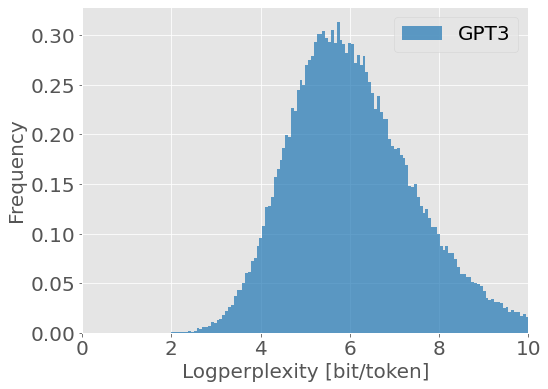

In [6]:
from scipy.stats import norm

IGNORE_FIRST_SENTENCE = True
if context == 'previous_sentence' or IGNORE_FIRST_SENTENCE:
    data_disp = datar[datar.num>1]

tt = np.linspace(0,10,157)
data_disp.groupby('author').response.plot.hist(bins = tt, density=True, alpha=.7, legend=True, 
                                               color={machine_author : 'tab:blue',human_author:'tab:orange'})
plt.legend(fontsize=20)
plt.ylabel('Frequency', size=20)
plt.xlabel('Logperplexity [bit/token]', size=20)

fig = plt.gcf()
fig.set_size_inches(8, 6, forward=True)

plt.xlim((0,10))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

#plt.savefig(f"Figs/{name}.png")
plt.show()
#

## Perplexity Vs. Length

In [7]:
def plot_perp_vs_len(data, min_len=5, max_len=160):
    df_grouped = (
        data[['length', 'response']][(data['length'] >= min_len)
                                    & (data['length'] <= max_len)
                                    ].groupby(['length']).agg(['mean', 'std', 'count'])
    )
    df_grouped = df_grouped.droplevel(axis=1, level=0).reset_index()
    # Calculate a confidence interval as well.
    df_grouped['ci'] = 1.96 * df_grouped['std'] / np.sqrt(df_grouped['count'])
    df_grouped['ci_lower'] = df_grouped['mean'] - df_grouped['ci']
    df_grouped['ci_upper'] = df_grouped['mean'] + df_grouped['ci']
    df_grouped.head()

    fig, ax = plt.subplots()
    x = df_grouped['length']
    ax.plot(x, df_grouped['mean'])
    ax.fill_between(
        x, df_grouped['ci_lower'], df_grouped['ci_upper'], color='b', alpha=.15)
    ax.set_ylim(ymin=0)
    #ax.set_title('log perplexity vs. length')
    ax.set_xlabel("Length [token]", fontsize=20)
    ax.set_ylabel("Logperplexity [bit/token]", fontsize=20)
    ax.set_ylim((2, 4))
    plt.rcParams["figure.figsize"] = (8, 6)


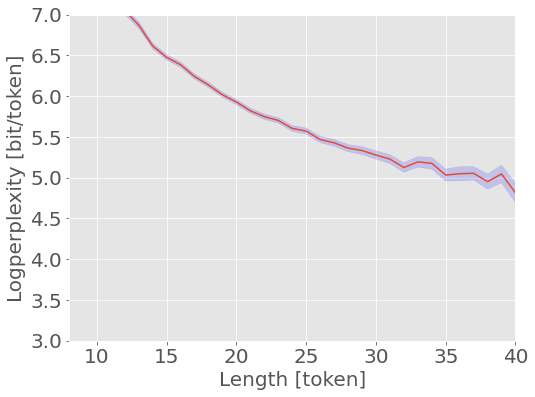

In [10]:
IGNORE_FIRST_SENTENCE = True
if context == 'previous_sentence' or IGNORE_FIRST_SENTENCE:
    data_disp = datar[datar.num>1]

plot_perp_vs_len(data_disp, min_len=5, max_len=50)
#plt.title("LogPerp vs. sentence length")
plt.ylim([3,7])
plt.xlim([8,40])
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

#plt.savefig(f"Figs/logperp_vs_len_{name}.png")
plt.show()

# Survival Function

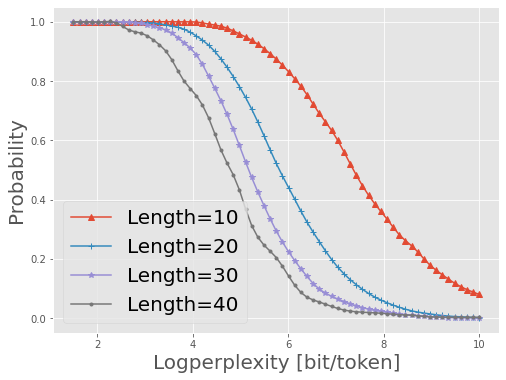

In [12]:
from src.fit_survival_function import fit_per_length_survival_function

def get_survival_function(df, G=101):
    """
    One survival function for every sentence length in tokens

    Args:
    :df:  data frame with columns 'response' and 'length'

    Return:
        bivariate function (length, responce) -> (0,1)

    """
    assert not df.empty
    value_name = "response" if "response" in df.columns else "logloss"

    df1 = df[~df[value_name].isna()]
    ll = df1['length']
    xx1 = df1[value_name]
    return fit_per_length_survival_function(ll, xx1, log_space=True, G=G)

df_null = datar[datar.num > 1]
pval_functions = get_survival_function(df_null, G=53)

tt = np.linspace(1.5, 10, 67)
ll = [10, 20, 30, 40]

plt.rcParams["figure.figsize"] = (8, 6)
marks = ['^', '+', '*', '.']
for i,l in enumerate(ll):
    mark = marks[i]
    plt.plot(tt, pval_functions(l, tt)[0], mark + '-', label=f"Length={l}")

plt.xlabel("Logperplexity [bit/token]", fontsize=20)
plt.ylabel("Probability", fontsize=20)
plt.legend(fontsize=20)
#plt.savefig(f"Figs/survival_func_{name}.png")
plt.show()

 # Perplexity of first sentences vs. the rest

<Figure size 576x432 with 0 Axes>

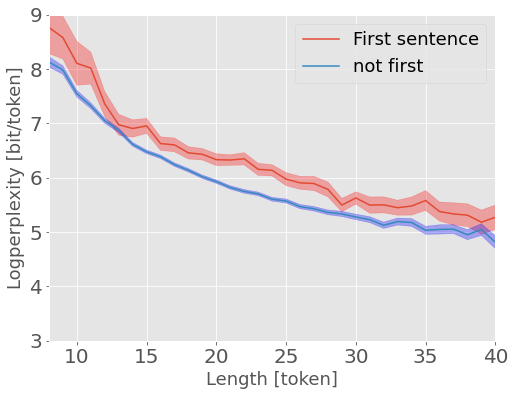

In [17]:
plt.figure()

min_len = 5
max_len = 50

data = datar[datar.num == 1]
df_grouped = (
        data[['length', 'response']][(data['length'] >= min_len)
                                        & (data['length'] <= max_len)
                                       ].groupby(['length']).agg(['mean', 'std', 'count'])
    )
df_grouped = df_grouped.droplevel(axis=1, level=0).reset_index()
# Calculate a confidence interval as well.
df_grouped['ci'] = 1.96 * df_grouped['std'] / np.sqrt(df_grouped['count'])
df_grouped['ci_lower'] = df_grouped['mean'] - df_grouped['ci']
df_grouped['ci_upper'] = df_grouped['mean'] + df_grouped['ci']
df_grouped.head()

fig, ax = plt.subplots()
x = df_grouped['length']
ax.plot(x, df_grouped['mean'], label='First sentence')
ax.fill_between(
    x, df_grouped['ci_lower'], df_grouped['ci_upper'], color='r', alpha=.3)

# second
data = datar[datar.num >= 2]
df_grouped = (
        data[['length', 'response']][(data['length'] >= min_len)
                                        & (data['length'] <= max_len)
                                       ].groupby(['length']).agg(['mean', 'std', 'count'])
    )
df_grouped = df_grouped.droplevel(axis=1, level=0).reset_index()
# Calculate a confidence interval as well.
df_grouped['ci'] = 1.96 * df_grouped['std'] / np.sqrt(df_grouped['count'])
df_grouped['ci_lower'] = df_grouped['mean'] - df_grouped['ci']
df_grouped['ci_upper'] = df_grouped['mean'] + df_grouped['ci']
df_grouped.head()

x = df_grouped['length']
ax.plot(x, df_grouped['mean'], label='not first')
ax.fill_between(
    x, df_grouped['ci_lower'], df_grouped['ci_upper'], color='b', alpha=.3)

ax.legend()
ax.set_ylim(ymin=0)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

plt.legend(fontsize=18)

#ax.set_title('log perplexity vs. length')
ax.set_xlabel("Length [token]", fontsize=18)
ax.set_ylabel("Logperplexity [bit/token]", fontsize=18)
plt.rcParams["figure.figsize"] = (8,6)

plt.ylim([3,9])
plt.xlim([8,40])
#plt.savefig(f"Figs/logperp_vs_len_first_sentence_{name}.png")
plt.show()

# Skewness and Kurtosis

In [18]:
def kurtosis(x):
    return scipy.stats.kurtosis(x)
agg_stats = datar.groupby('author').response.agg(['mean','median', 'std', 'skew', kurtosis])
print(agg_stats)

            mean    median       std      skew  kurtosis
author                                                  
GPT3    6.138218  5.962462  1.480186  0.781048   1.25308


# Critical Values

In [141]:
#from src.fit_HC_survival_function import get_HC_survival_function
import numpy as np
from multitest import MultiTest
from tqdm import tqdm
from scipy.interpolate import RectBivariateSpline
from src.fit_survival_function import fit_survival_func


xx = {}
nn = [25, 50, 75, 100, 125, 150, 200, 250, 300, 400, 500]
for n in nn:
    yy = np.zeros(nMonte)
    for j in tqdm(range(nMonte)):
        uu = np.random.rand(n)
        mt = MultiTest(uu, stbl=STBL)
        yy[j] = mt.hc()[0]
    xx[n] = yy

100%|██████████| 10000/10000 [00:00<00:00, 15441.31it/s]


In [142]:
log_space = True
xx0 = np.linspace(-1, 10, 57)
zz = []
for n in nn:
    univariate_survival_func = fit_survival_func(xx[n], log_space=log_space)
    zz.append(univariate_survival_func(xx0))
    
func_log = RectBivariateSpline(np.array(nn), xx0, np.vstack(zz))

if log_space:
    def func(x, y):
        return np.exp(-func_log(x,y))
else:
    func = func_log


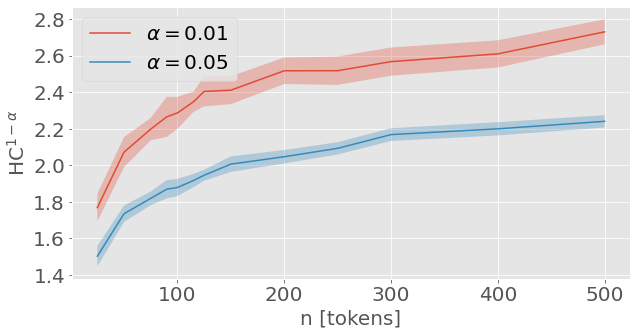

In [5]:
plt.figure()
fig = plt.gcf()
fig.set_size_inches(10, 5, forward=True)

df = pd.read_csv('HC_critvals.csv')

nn = df['n'].unique()
colors = ['tab:blue', 'tab:red']
for c in df.groupby('alpha'):
    yy = c[1]['q_alpha'].values
    plt.plot(nn, yy, label=fr'$\alpha={c[0]}$')
    cu = yy + 1.96*c[1]['std'].values
    cl = yy - 1.96*c[1]['std'].values
    plt.fill_between(nn, cl, cu, alpha=.3)

plt.xticks(fontsize=20); plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.xlabel('n [tokens]', fontsize=20)
plt.ylabel(r'$\mathrm{HC}^{1-\alpha}$', fontsize=20)


plt.savefig("Figs/HC_critvals.png")
plt.show()

In [3]:
from src.fit_HC_survival_function import get_HC_survival_function